## 3. 単純ベイズ法による異常検知

### 多次元の問題を1次元に帰着する

$M$次元ベクトル$\boldsymbol{x}$に加えて、異常か正常かを示すラベル$y$が同時に観測されている場合。  
$N$個の標本を含むデータが観測されているとする。
$$
D=\{(\boldsymbol{x}^{(1)},y^{(1)}),(\boldsymbol{x}^{(2)},y^{(2)}),\cdots,(\boldsymbol{x}^{(N)},y^{(N)})\}
$$

**単純ベイズ法(ナイーブベイズ法)** は、変数ごと(変数の次元ごと)に問題を切り分けるという単純な方法で解決する手法である。
単純ベイズ法ではモデルとして次のようなものを仮定する。
$$
p(\boldsymbol{x}|y)=p(x_1|y)p(x_2|y)\cdots p(x_M|y)=\prod_{i=1}^Mp(x_i|y)
$$

>**定理1(変数が統計的に独立な場合の最尤推定)**
モデルが変数ごとに積の形となっている場合、$M$変数のそれぞれに対して別々に最尤推定することで、モデルのパラメータを求めることができる。

### 独立変数モデルのもとでのホテリングの$T^2$法
変数の独立性を仮定するモデルはラベルなしデータでも適用できる。
例としてホテリングの$T^2$法でこの考え方を使う。
$M$次元ベクトル$\boldsymbol{x}$がN個観測されているとする。

$$
D=\{\boldsymbol{x}^{(1)},\boldsymbol{x}^{(2)},\cdots,\boldsymbol{x}^{(N)}\}
$$
確率分布のモデルとして、通常の多変量正規分布の代わりに、
$$
p(\boldsymbol{x})=\prod_{i=1}^MN(x_i|\mu_i,\Sigma_{ii})=\prod_{i=1}^M\frac{1}{\sqrt{2\pi\Sigma_{ii}}}\exp{\biggl\{-\frac{1}{2\Sigma_{ii}(x_i-\mu_i)^2} \biggr\}}
$$

共分散行列の非対角成分をすべて0と置いたものである。
対数尤度を$\mu_i$および$\Sigma_{ii}$に対して微分して0と等値することにより最尤解が得られる。
$$
\hat{\mu_i}=\frac{1}{N}\sum_{i=1}^Nx_i^{(n)}\\
\hat{\Sigma_{ii}}=\hat{\sigma}_i^2=\frac{1}{N}\sum_{i=1}^N(x_i^{(n)}-\hat{\mu_i}^2)
$$

多変量正規分布の異常度
$$
a(\boldsymbol{x'})=(\boldsymbol{x'}-\hat{\boldsymbol{\mu}})^T\hat{\Sigma}^{-1}(\boldsymbol{x'}-\hat{\boldsymbol{\mu}})
$$
から、異常度を計算すると
$$
a(\boldsymbol{x'})=\sum_{i=1}^M\biggl(\frac{x_i'-\hat{\mu_i}}{\hat{\sigma}_i} \biggr)^2
$$

となり、$M$個の変数のそれぞれに対して計算された異常度の和となる。

In [93]:
import numpy as np
from scipy import linalg

def box_muller(n):
    """乱数の発生
    """
    r1 = np.random.rand(n)
    r2 = np.random.rand(n)

    x = np.sqrt(-2*np.log(r1)) * np.sin(2*np.pi*r2)
    return x

def sampling_gaus(n, sample, mu, sigma):
    """ガウス分布からのサンプリング
    """
    L = np.linalg.cholesky(sigma)

    Y = np.array([np.dot(L, box_muller(n)) for _ in range(sample)]) + mu
    return Y

(-8.0, 10.0)

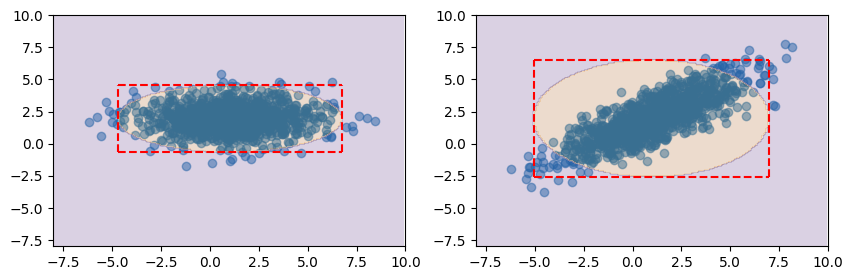

In [67]:
from scipy.stats import chi2
import matplotlib.pyplot as plt

# 有意水準
alpha = 0.01

# 閾値
ath = chi2.ppf(q=1-alpha, df=1, scale=1)

# 図用の座標
x = np.arange(-10,10,0.1)
y = np.arange(-10,10,0.1)
xy =np.meshgrid(x,y)
xy = np.array(xy).T

fig ,axes = plt.subplots(nrows=1, ncols=2, figsize=(5*2, 3*1))

# 変数間に相関がない場合
data = sampling_gaus(2, 1000, [1,2], [[5, 0], [0,1]])

# 異常度の計算
a = np.sum((((xy - data.mean(axis=0))/data.std(axis=0))**2), axis=2)
x1_up, x2_up = np.sqrt(ath)*data.std(axis=0)+data.mean(axis=0)
x1_low, x2_low = -np.sqrt(ath)*data.std(axis=0)+data.mean(axis=0)

ax = axes[0]
ax.scatter(data[:,0], data[:,1], alpha=.5);
ax.contourf(xy[:,:,0],xy[:,:,1],a>ath, alpha=.2, cmap='PuOr')
ax.hlines([x2_low,x2_up],x1_low,x1_up, 'red', '--')
ax.vlines([x1_low,x1_up],x2_low,x2_up, 'red', '--')
ax.set_xlim(-8, 10)
ax.set_ylim(-8, 10)

# 変数間に相関がある場合
data = sampling_gaus(2, 1000, [1,2], [[5, 3], [3, 3]])

# 異常度の計算
a = np.sum((((xy - data.mean(axis=0))/data.std(axis=0))**2), axis=2)
x1_up, x2_up = np.sqrt(ath)*data.std(axis=0)+data.mean(axis=0)
x1_low, x2_low = -np.sqrt(ath)*data.std(axis=0)+data.mean(axis=0)

ax = axes[1]
ax.scatter(data[:,0], data[:,1], alpha=.5);
ax.contourf(xy[:,:,0],xy[:,:,1],a>ath, alpha=.2, cmap='PuOr')
ax.hlines([x2_low,x2_up],x1_low,x1_up, 'red', '--')
ax.vlines([x1_low,x1_up],x2_low,x2_up, 'red', '--')
ax.set_xlim(-8, 10)
ax.set_ylim(-8, 10)

### 多項分布による単純ベイズ分類
代表例として、迷惑メールの振り分け問題がある。
迷惑メールフィルタは、それぞれにおける単語の頻度を計算し、それを各メールを特徴づける特徴量として使用する。
$M$を列挙する単語の数とすると、1つのメールは単語の頻度を単語ごとに集計したベクトルとして

$$
\boldsymbol{x}=(0,0,0,1,0,0,2,0,0,\cdots)^T
$$
と表される。
このようなモデルを**単語袋詰め(bag-of-words)**モデルと呼ぶ。
$\boldsymbol{x}$の分布は、各単語の出現確率$\theta_1,\theta_2,\cdots,\theta_M$で表現できる。

$$
Mult(\boldsymbol{x}|\boldsymbol{\theta})=\frac{(x_1+\cdots+x_M)!}{x_1!\cdots x_M!}\theta_1^{x_1}\cdots \theta_M^{x_M}
$$

これを**多項分布**と呼ぶ。

#### 多項分布の最尤推定
過去のメールが$N$通、迷惑メール($y=1$)か普通のメール($y=0$)のフラグと共に蓄積されているとする。  
最初のステップは$y$ごとに$\boldsymbol{x}$の分布を求める。  
$y=0$と$1$に対応して、$Multi(\boldsymbol{x}|\boldsymbol{\theta}^0)$と$Multi(\boldsymbol{x}|\boldsymbol{\theta}^1)$という2つモデルを仮定し、未知パラメータ$\boldsymbol{\theta}^0$と$\boldsymbol{\theta}^1$を最尤推定する。  
対数尤度は次のように書ける。
$$
L(\boldsymbol{\theta}^0,\boldsymbol{\theta}^1|D)=\sum_{n\in D^1}\sum_{i=1}^Mx_i^{(n)}\ln{\theta_i^1}+\sum_{n\in D^0}\sum_{i=1}^Mx_i^{(n)}\ln{\theta_i^0}+(定数)
$$

この$L(\boldsymbol{\theta}^0,\boldsymbol{\theta}^1|D)$を、制約$\sum_{i=1}^M\theta_i^1=1$および$\sum_{i=1}^M\theta_i^0=1$のもとで最大化することである。 


次のように解が得られる。
$$
\hat{\theta}_i^0=\frac{\sum_{i\in D^0}x_i^{(n)}}{\sum_{i=1}^M\sum_{i\in D^0}x_i^{(n)}}=\frac{D^0における単語iの出現総数}{D^0における全単語の出現総数}\\
\hat{\theta}_i^1=\frac{\sum_{i\in D^1}x_i^{(n)}}{\sum_{i=1}^M\sum_{i\in D^1}x_i^{(n)}}=\frac{D^1における単語iの出現総数}{D^1における全単語の出現総数}
$$

この式だと、訓練データに1度も出てない単語についてパラメータは0になってしまうので、  
単語の頻度についてゲタをはかせるのが一般的であり、**スムージング**と呼ぶ。  
たとえば、$\gamma>0$を$x_i^{(n)}$に加えたとすれば、
$$
\hat{\theta}_i^y=\frac{N_i^y+\gamma}{|D^y|+M\gamma}
$$
のような解となる。  
$N_i^y$は$D^y$における単語$i$の出現数、$|D^y|$は$D^y$における全単語の出現総数のことである。  
  
#### 迷惑メールの分類
最後のステップとして、未知のメールの単語袋詰め表現$\boldsymbol{x'}$が得られたとして、これを迷惑メール$(y'=1)$か普通メール$(y'=0)$かに分類する。  
$p(\boldsymbol{x'}|y,D)$が多項分布に対応しているので、判定スコアの式は次のように得られる。
$$
\begin{align}
a(\boldsymbol{x'})&=\ln{\frac{p(\boldsymbol{x'}|y=1,D)}{p(\boldsymbol{x'}|y=0,D)}}\\
&=\sum_{i=1}^Mx_i'\ln{\frac{\hat{\theta}_i^1}{\hat{\theta}_i^0}}
\end{align}
$$

$\alpha_i=\ln{(\hat{\theta}_i^1/\hat{\theta}_i^0)}$により係数ベクトル$\boldsymbol{\alpha}$を定義すると、$a(\boldsymbol{x'})=\boldsymbol{\alpha}^T\boldsymbol{x'}$のような簡潔な式になる。  
これは多項分布に基づく単純ベイズ分類が、本質的には線形分類器であることを意味する。  
  
単純ベイズ分類による迷惑メールの分類のアルゴリズムを示す。
>用語集を作っておく(単語数$M$)、スムージングの定数$\gamma$を決める(もっとも単純には$\gamma=1$とする)
>- 訓練時(最尤推定)  
・閾値決定用の検証データを訓練データとは別に取り分けておく  
・訓練データ内の$y=1$の標本(個々のメール)から、単語$i$の出現頻度$N_i^1$を数える$(i=1,\cdots,M)$  
・$|D^1|=\sum_{i=1}^MN_i^1$を計算し、$\{\theta_i^1\}$を求める  
・$y=0$の標本についても同様にして$\{\theta_i^0\}$を求める  
・各$i$につき$\alpha_i=\ln{(\hat{\theta}_i^1}/\hat{\theta}_i^0)$を計算して記憶する  
>- 訓練時(閾値の最適化)  
・検証データ内の標本に対して異常度$a(\boldsymbol{x})=\boldsymbol{\alpha}^T\boldsymbol{x}$を計算する  
・正常標本精度と異常標本精度の図を作り、異常判定の閾値$a_{th}$を決める  
>- 運用時  
・やってきたメールの単語を数え、単語袋詰め表現$\boldsymbol{x'}$を求める  
・異常度$a(\boldsymbol{x'})=\boldsymbol{\alpha}^T\boldsymbol{x'}$を計算する  
・$a(\boldsymbol{x'})>a_{th}$なら迷惑メールと判定する  

In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読み込み
df = pd.read_csv('spam.csv', encoding='latin-1')

# 検証データと訓練データを分ける
X = pd.DataFrame(df['Message'])
Y = pd.DataFrame(df['Type'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, test_size=0.3, random_state=10)

df.head()

,Type,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [74]:
from sklearn.feature_extraction.text import CountVectorizer

# 訓練データの単語の出現頻度を数える
vec_count = CountVectorizer(min_df=3)
vec_count.fit(X_train['Message'])

# 単語数 M
M = len(vec_count.vocabulary_)
print('word size: ', M)
# 先頭５件の単語を表示
print('word content: ', dict(list(vec_count.vocabulary_.items())[0:5]))

word size:  423
word content:  {'sorry': 321, 'll': 209, 'call': 61, 'later': 198, 'in': 181}


In [75]:
# 各文書をBoWに変換
X_train_vec = vec_count.transform(X_train['Message'])
X_test_vec = vec_count.transform(X_test['Message'])

pd.DataFrame(X_train_vec.toarray()[0:5], columns=vec_count.get_feature_names_out())

,000,10,100,1000,10p,11,150p,150ppm,16,18,...,www,xxx,ya,yeah,yes,yo,you,your,yr,yup
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


D1:  1196
D0:  4233


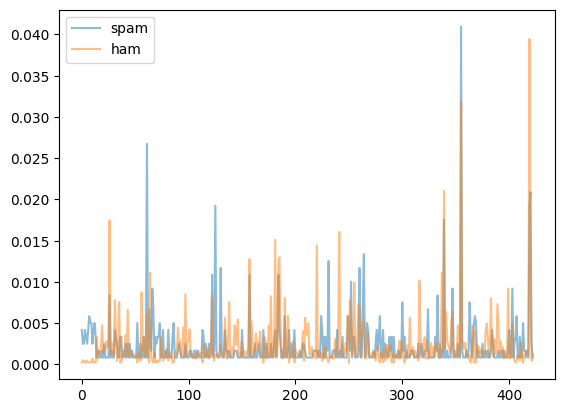

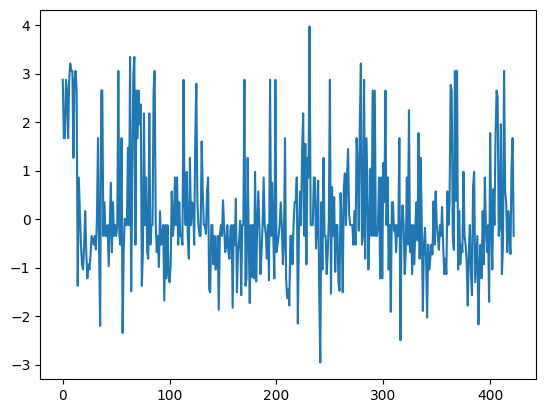

In [77]:
# スパム(spam)と正常(ham)に分ける
X_train_vec1 = X_train_vec.toarray()[Y_train['Type']=='spam']
X_train_vec0 = X_train_vec.toarray()[Y_train['Type']=='ham']

gamma = 1
# 各単語の出現総数
N1 = np.sum(X_train_vec1, axis=0) + gamma
N0 = np.sum(X_train_vec0, axis=0) + gamma

# 全単語の出現総数
D1 = np.sum(N1)
D0 = np.sum(N0)
print('D1: ', D1)
print('D0: ', D0)

# 各単語の出現確立
theta1 = N1 / D1
theta0 = N0 / D0

plt.plot(theta1, alpha=.5, label='spam');
plt.plot(theta0, alpha=.5, label='ham');
plt.legend();
plt.show()

# 係数ベクトル
alpha = np.log(theta1 / theta0)
plt.plot(alpha);

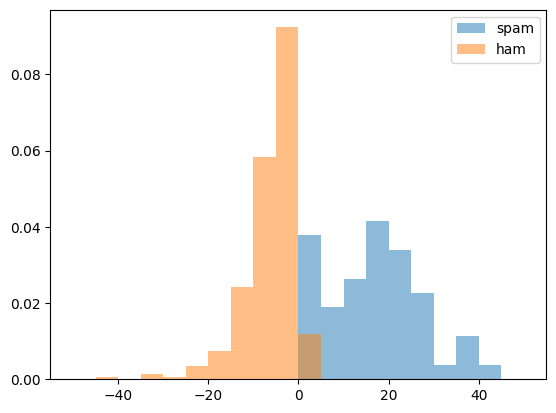

In [83]:
# 判定スコアの計算
a1 = alpha@X_train_vec1.T
a0 = alpha@X_train_vec0.T

plt.hist(a1, alpha=.5, range=(-50,50), bins=20, density=True, label='spam');
plt.hist(a0, alpha=.5, range=(-50,50), bins=20, density=True, label='ham');
plt.legend();

In [88]:
# 正常・異常データをまとめておく
x = np.append(a1, a0)
y = np.array([1]*len(Y_train[Y_train['Type']=='spam']) + [0]*len(Y_train[Y_train['Type']=='ham']))

# 正常標本精度と異常標本精度の計算
def make_accuracy(thresh=0.5):
    TP = np.sum((x > thresh).astype(int)*y) / np.sum(y==1)
    TF = np.sum((x <= thresh).astype(int)*(1-y)) / np.sum(y==0)
    return TP, TF

xx = np.arange(-75, 75, 0.5)
result = np.array([make_accuracy(thresh=t) for t in xx])

性能分岐点:  1.0


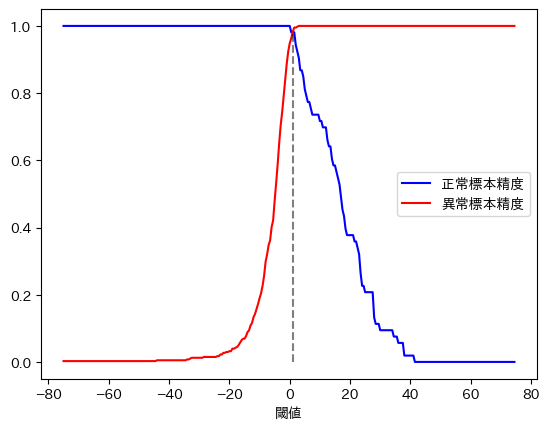

In [89]:
import japanize_matplotlib

# 正常標本精度と異常標本精度から分岐点の決定
idx_be = np.argmin(np.abs(result[:,0] - result[:,1]))
a_th = xx[idx_be]
print('性能分岐点: ', a_th)

plt.plot(xx, result[:,0], label='正常標本精度', color='blue');
plt.plot(xx, result[:,1], label='異常標本精度', color='red');
plt.vlines(a_th, 0, result[idx_be,0], linestyles='--', color='black', alpha=.5)
plt.legend();
plt.xlabel('閾値');

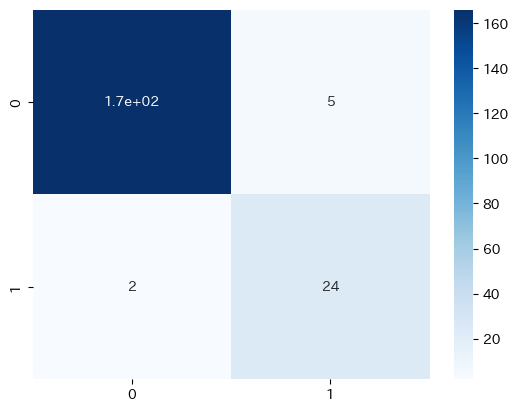

In [91]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 
y_true = np.array(Y_test['Type']=='spam').astype(int)

a_pred = alpha@X_test_vec.T
y_pred = (a_pred >= a_th).astype(int)

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues');

### 二値分類と異常検知の関係
**ベイズ決定則**は以下で定義される。
>もし
$$
\ln{\frac{p(y=1|\boldsymbol{x})}{p(y=0|\boldsymbol{x})}}>0
$$
ならば$y=1$と判定

ある任意の標本$\boldsymbol{x}$が与えられたときにそれを$y=0$または$y=1$に分類するとし、その判定規則を
$$
\tilde{a}(\boldsymbol{x})\geq \tau ならばy=1
$$
のように書くことにする。  
誤り確率は次のように書ける。
$$
(誤り確率)=\int d\boldsymbol{x}I[\tilde{a}(\boldsymbol{x})\geq\tau]p(y=0|\boldsymbol{x})p(\boldsymbol{x})\\
　　　　　　　+\int d\boldsymbol{x}\{1-I[\tilde{a}(\boldsymbol{x})\geq\tau]\}p(y=1|\boldsymbol{x})p(\boldsymbol{x})
$$

$p(y=1|\boldsymbol{x})p(\boldsymbol{x})$を$\boldsymbol{x}$について微分したものは$p(y=1)$であるので次のように変形できる。
$$
(誤り確率)=p(y=1)+\int d\boldsymbol{x}I[\tilde{a}(\boldsymbol{x})\geq\tau]p(y=0|\boldsymbol{x})p(\boldsymbol{x})\biggl\{1-\frac{p(y=1|\boldsymbol{x})}{p(y=0|\boldsymbol{x})} \biggr\}
$$

これを最小にする$\tilde{a}$の関数形を選ぶ。  
$\{\}$の中身で負の領域をすべて拾えるように決めればよいので、
$$
\tilde{a}(\boldsymbol{x})=\ln{\frac{p(y=1|\boldsymbol{x})}{p(y=0|\boldsymbol{x})}},　\tau=0
$$
が解として求められる。  
  
ベイズ決定則とネイマン・ピアソン決定則はよく似た形をしているが、微妙に違う。  
- ネイマン・ピアソン決定則では、$p(\boldsymbol{x}|y=1)$と$p(\boldsymbol{x}|y=0)$の比がある閾値を超えたら異常と判定
- ベイズ決定則では、$p(\boldsymbol{x}|y=1)p(y=1)$と$p(\boldsymbol{x}|y=0)p(y=0)$の比が1を超えたら異常と判定

異常検知の場合、ほとんど常に$p(y=1)<<p(y=0)$だから、ベイズ決定則は異常判定を強く抑制する傾向にあることが分かる。  
ベイズ決定則における固定した閾値を、実験的に決める調整パラメータと考えれば、ネイマン・ピアソン決定則と実質的な違いはなくなる。

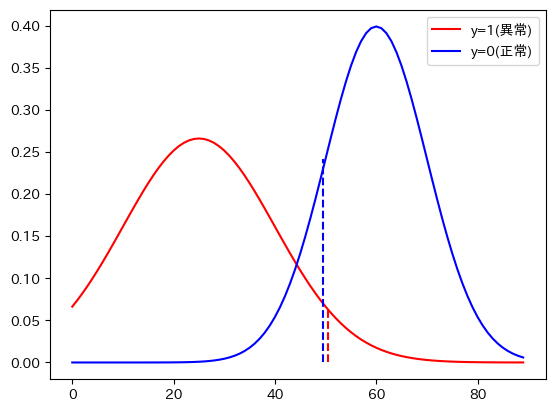

In [94]:
from scipy.stats import norm

x = np.arange(0,9, 0.1)

p1 = norm.pdf(x, 2.5, 1.5)
p0 = norm.pdf(x, 6, 1.)

plt.plot(p1, label='y=1(異常)', color='red');
plt.plot(p0, label='y=0(正常)', color='blue');
plt.vlines(50.5, 0, p1[50], linestyles='--', color='red')
plt.vlines(49.5, 0, p0[50], linestyles='--', color='blue')
plt.legend();

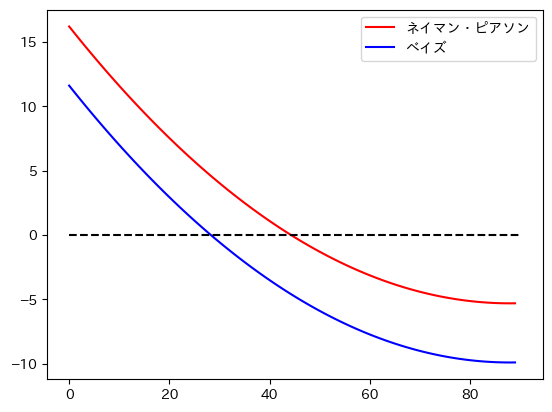

In [95]:
py0 = 0.99
py1 = 0.01

plt.plot(np.log(p1/p0), label='ネイマン・ピアソン', color='red');
plt.plot(np.log((p1*py1)/(p0*py0)), label='ベイズ', color='blue');
plt.hlines(0, 0, 90, linestyles='--', color='black');
plt.legend();